## 实现近似熵

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import lfilter, medfilt
from matplotlib.patches import Rectangle

### 1. 定义近似熵函数

In [3]:
def ApEn(x, m, r):                                             # 2. m：模式维数， r：相似容限
    N = len(x)                                                      # 1. 信号总长N
    x = np.array(x)
    if x.ndim != 1:
        raise ValueError("x的维度不是一维")
    if N < m + 1:
        raise ValueError("len(x)小于m+1")  
        
    phi = []
    for temp in range(2):  # 7.	将窗 m 增长为 m+1: temp = 0：m ； temp = 1: m+1
        # 3. 以m为窗，将时间序列分为k = n-m+1个序列
        X = []
        m = m+temp
        for i in range(N + 1 - m):
            X.append(x[i:i+m])
        X = np.array(X)
        
        # 4. 计算每个i与所有j之间的绝对值距离，获取统计个数：N_m(i)【count】
        C = []
        for index1, i in enumerate(X):
            count = 0
            for index2, j in enumerate(X):
                if index1 != index2:
                    if np.max(np.abs(i-j)) <= r:
                        count += 1
            # 5. 获取 C
            C.append(count/(N-m+1))
        # 处理C为0的值，替换为一个非零的很小的数,以防取对数时报错
        C = np.array(C)
        C = np.where(C == 0, 1e-10, C)
        
        # 6. 对每个C取自然对数，获取 Φ
        phi.append(np.sum(np.log(C))/(N-m+1))
        
    # 8. 获取近似熵
    apEn = phi[0] - phi[1]
    return apEn

### 2. 近似熵的应用

#### 2.1 简单的示例信号

x的相似容限： 0.25332113538577095
x的近似熵： 1.7882573191141962
x的相似容限： 0.3267646675039914
x的近似熵： 3.423490713358742


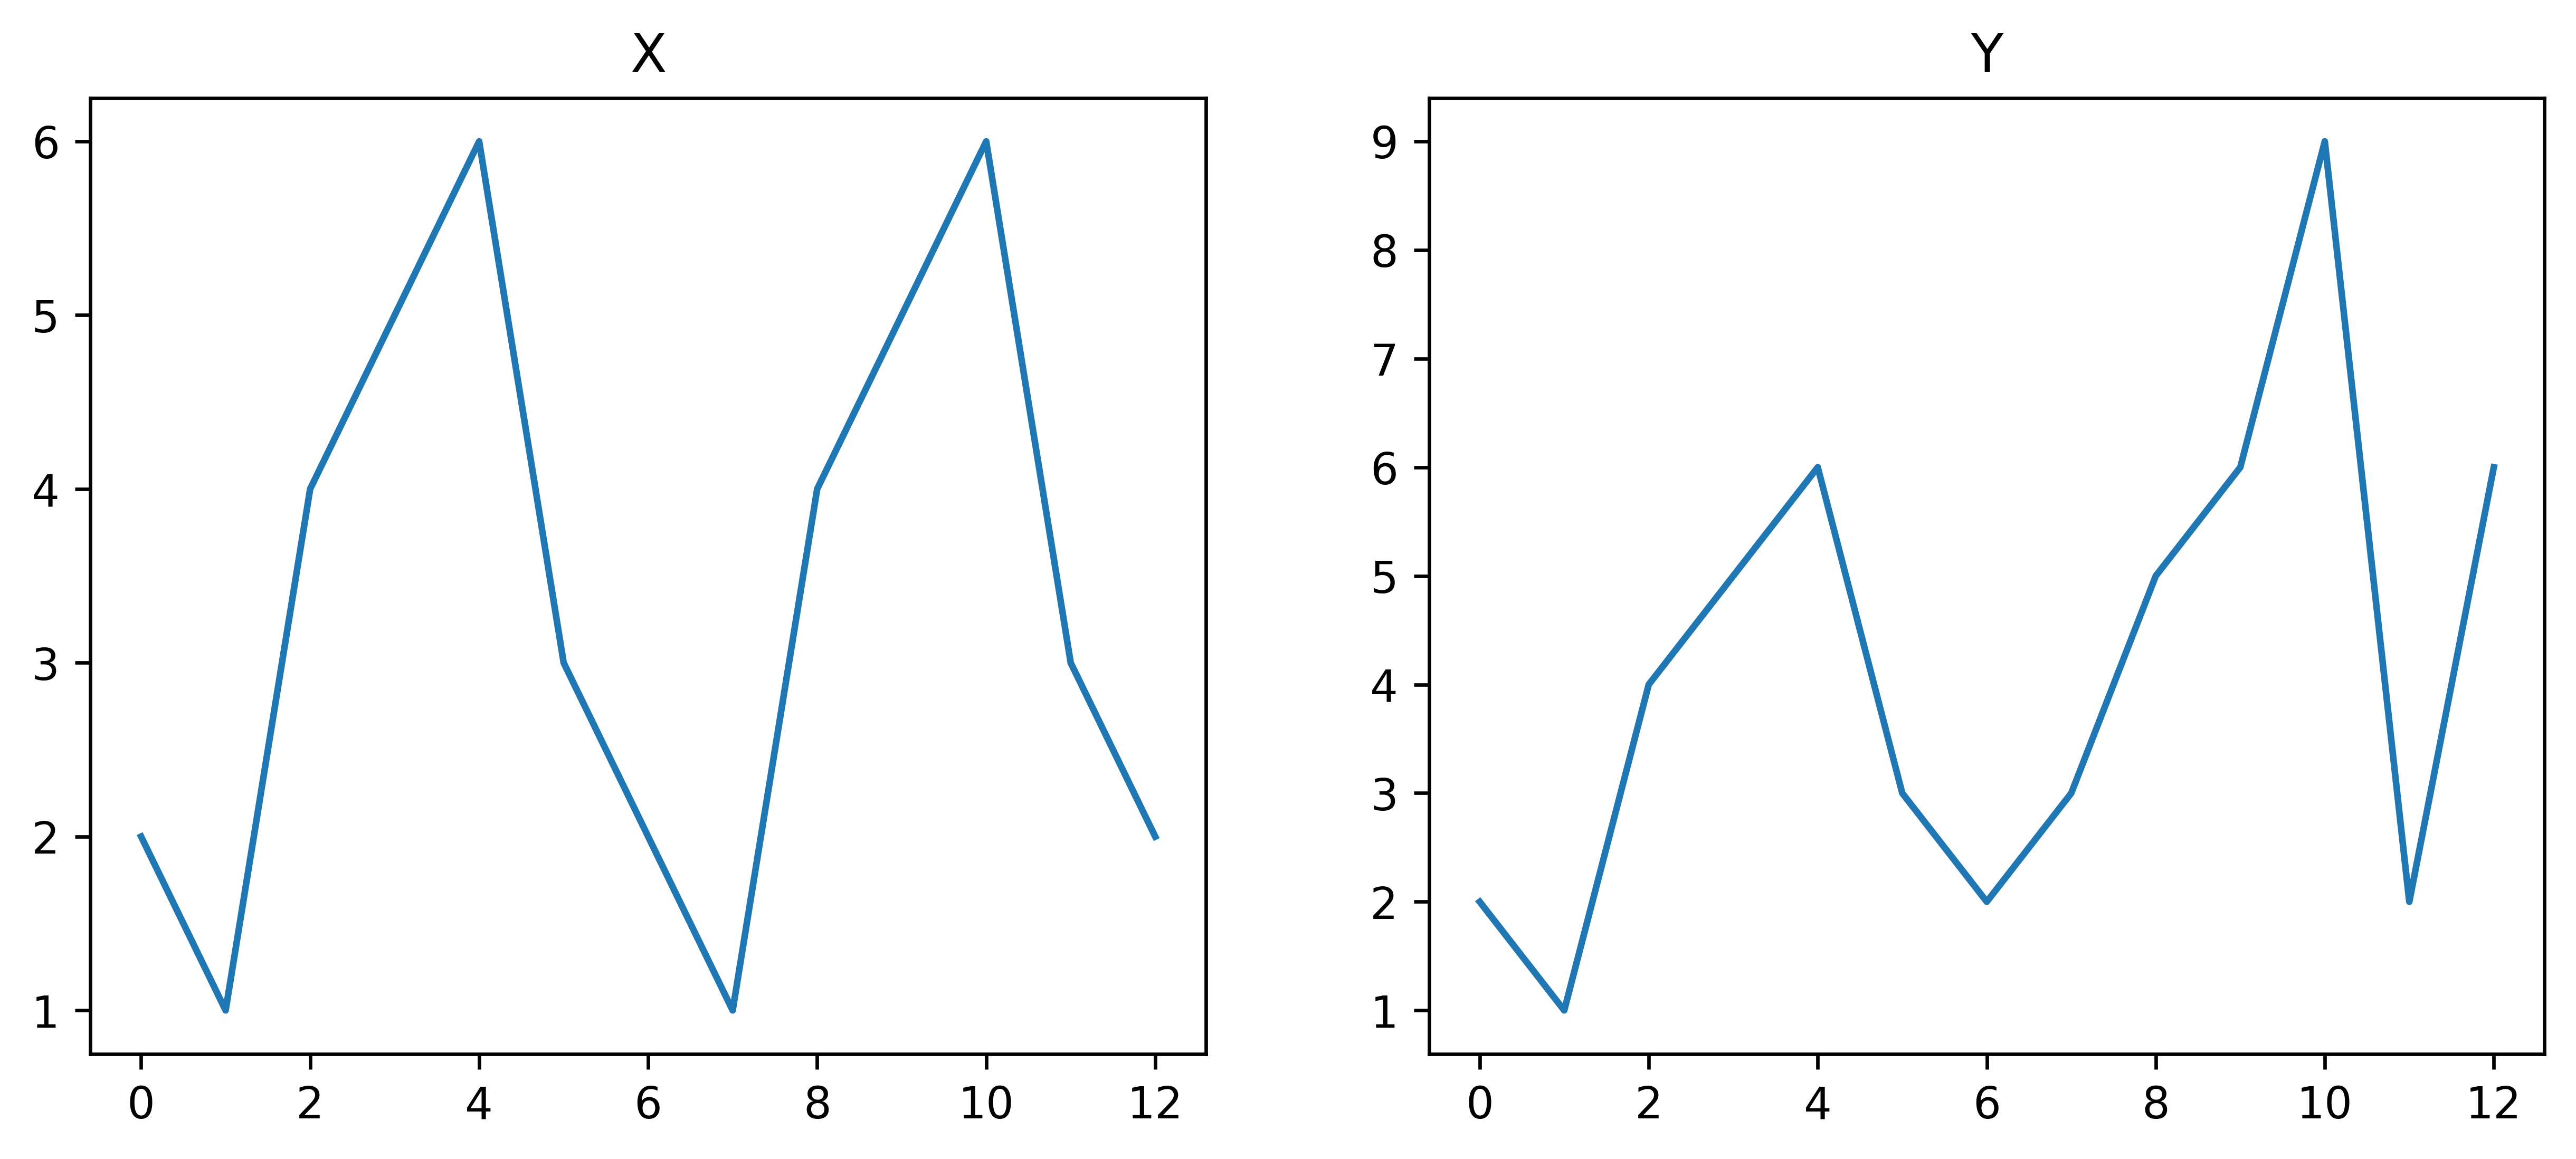

In [32]:
x = [2,1,4,5,6,3,2,1,4,5,6,3,2]    # x 规律
y = [2,1,4,5,6,3,2,3,5,6,9,2,6]    # y 不规律
plt.figure(figsize=(10,4), dpi=600)
plt.subplot(1,2,1)
plt.plot(x)
plt.title('X')
plt.subplot(1,2,2)
plt.plot(y)
plt.title('Y')


Xstd = np.std(x)
rx = 0.15*Xstd
apEnX = ApEn(x, 2, rx)
print('x的相似容限：', rx)
print('x的近似熵：', apEnX)

Ystd = np.std(y)
ry = 0.15*Ystd
apEnY = ApEn(y, 2, ry)
print('x的相似容限：', ry)
print('x的近似熵：', apEnY)

#### 2.2 模拟EEG的P300

##### 2.2.1 定义粉红噪声函数：粉红噪声的谱密度是随频率的增加而呈1/f衰减

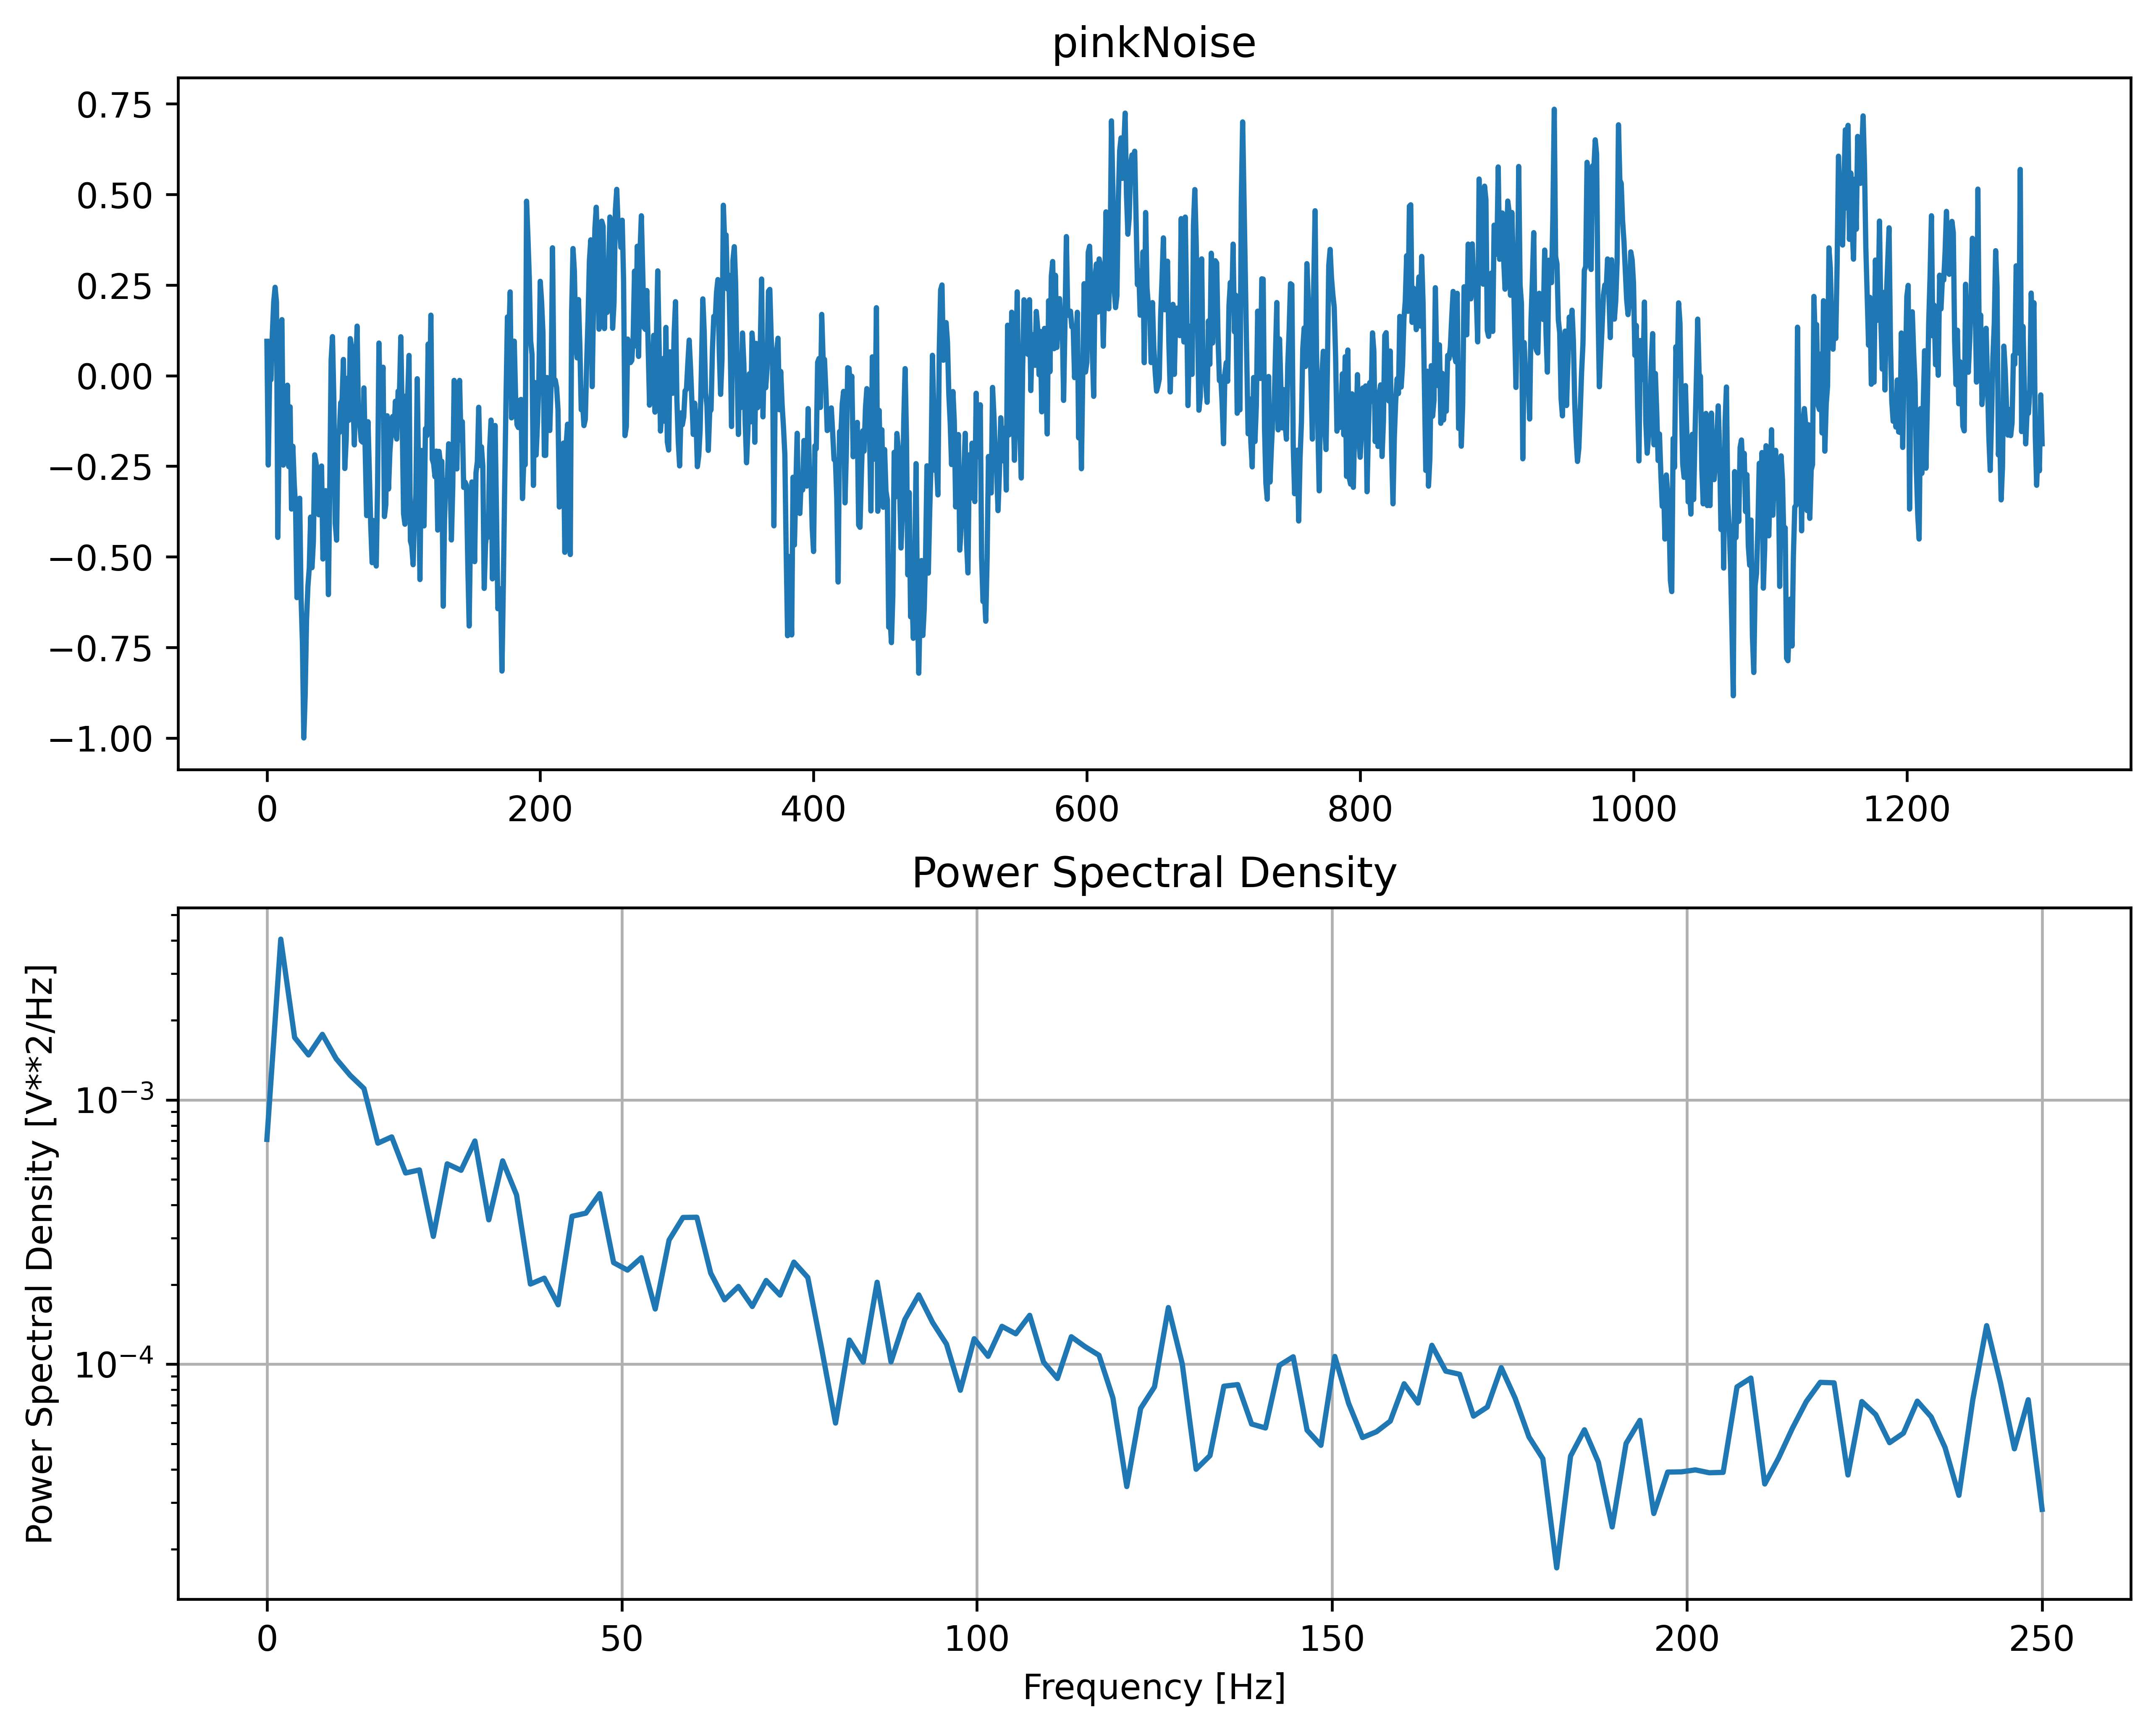

In [50]:
def generate_pink_noise(num_samples):
    # 创建白噪声
    white_noise = np.random.randn(num_samples)

    # 设置滤波器系数
    b = [0.049922035, -0.095993537, 0.050612699, -0.004408786]
    a = [1, -2.494956002, 2.017265875, -0.522189400]

    # 使用滤波器对白噪声进行滤波
    pink_noise = lfilter(b, a, white_noise)

    # 标准化粉红噪声的幅度范围
    pink_noise /= np.max(np.abs(pink_noise))

    return pink_noise

# 生成1000个样本的粉红噪声
pinkNoise = generate_pink_noise(1300)
# 绘制粉红噪声及其功率谱
plt.figure(figsize=(10,8), dpi = 600)
plt.subplot(2,1,1)
plt.plot(pinkNoise)
plt.title('pinkNoise')
# 计算信号的功率谱
f, Pxx = signal.welch(samples, 500)
plt.subplot(2,1,2)
plt.semilogy(f, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density [V**2/Hz]')
plt.title('Power Spectral Density')
plt.grid(True)
plt.show()

##### 2.2.2 构建P300信号：在粉红噪声上添加汉明窗

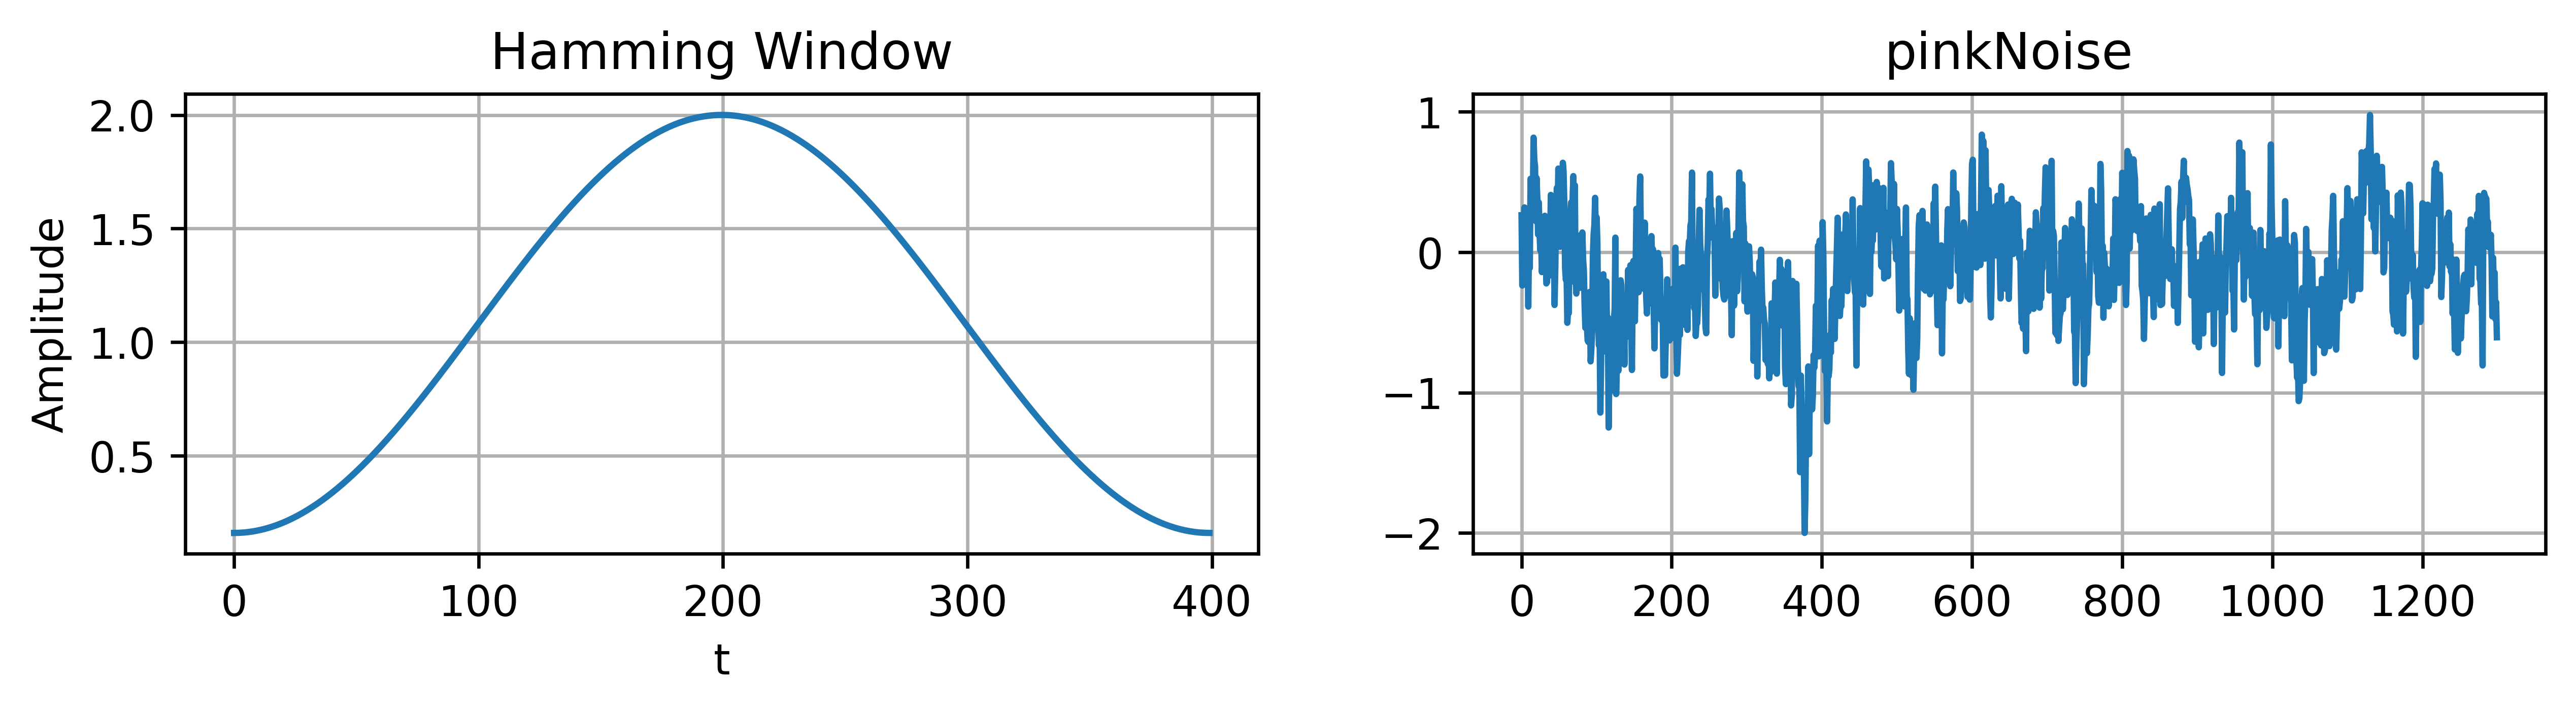

Text(0.5, 1.0, 'EEG_p300')

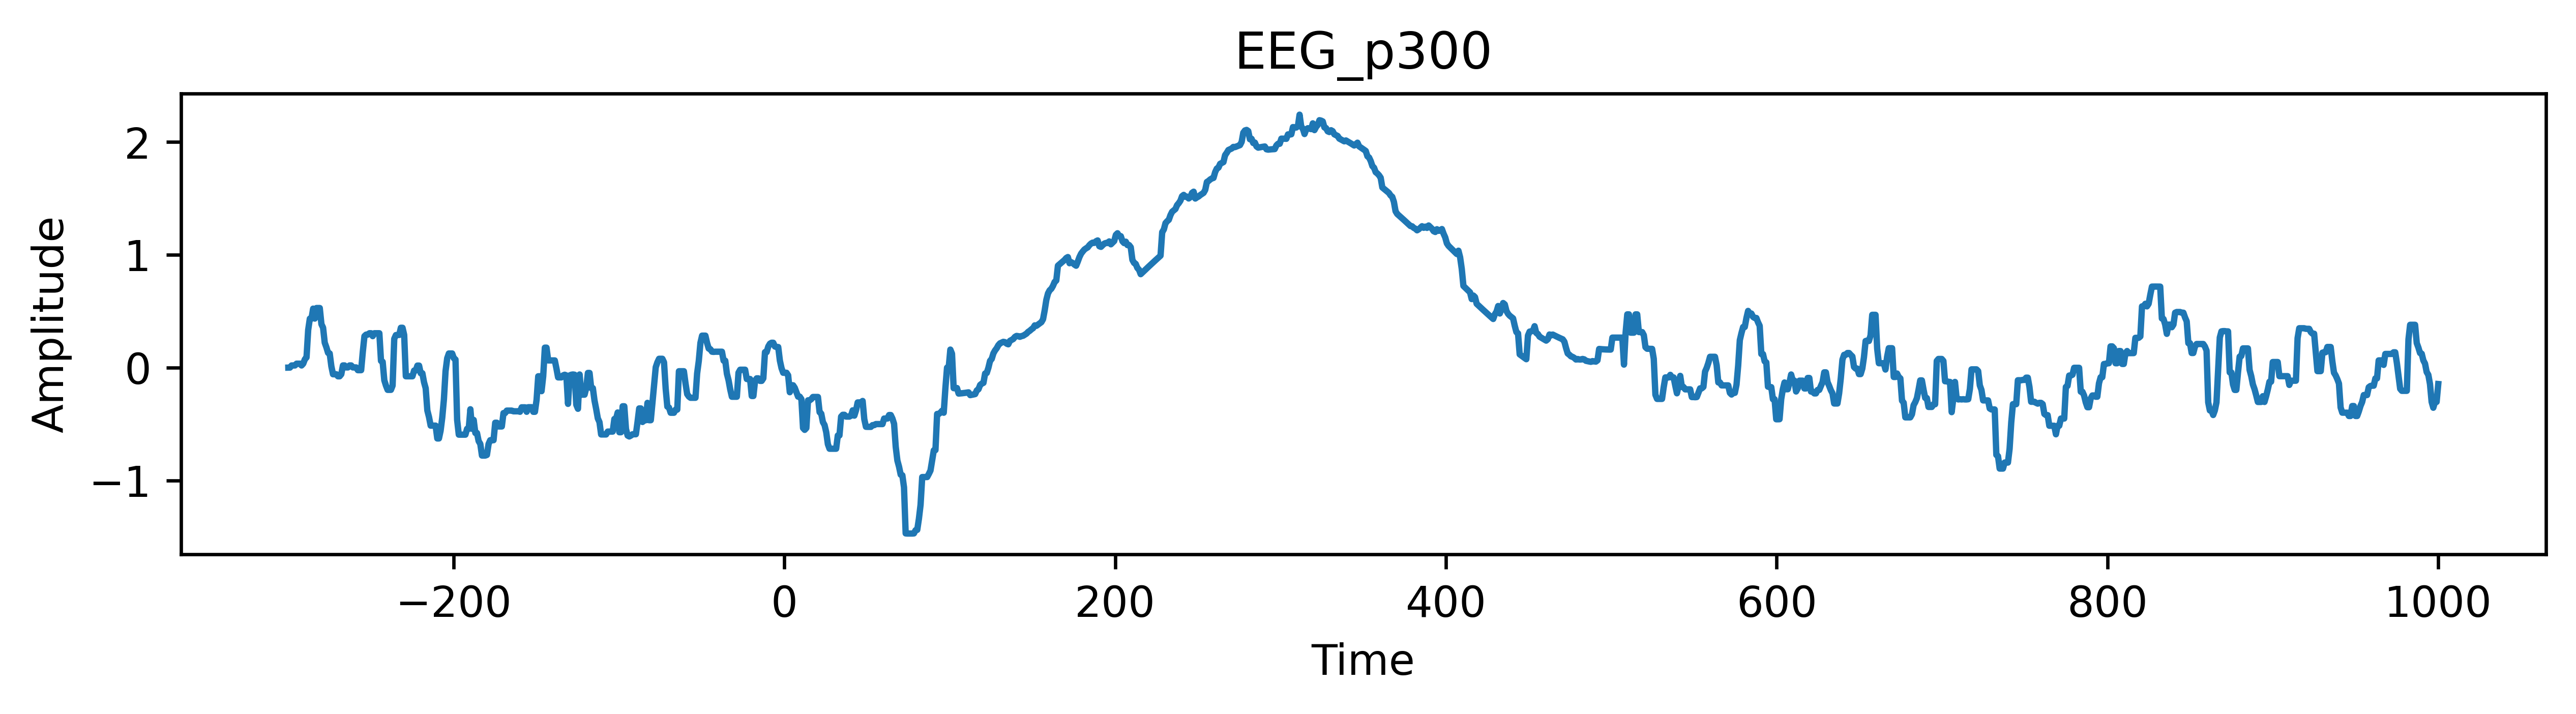

In [194]:
# 定义窗口长度
window_length = 400
# 构建汉明窗
hamming_window = np.hamming(window_length)

p_wave = hamming_window*2 
# 生成1000个样本的粉红噪声
pinkNoise = generate_pink_noise(1300)
pinknoise = pinkNoise*2

s1 = medfilt(pinknoise[0:400], kernel_size=7)
s2 = medfilt(pinknoise[400:800], kernel_size=25) + p_wave
s3 = medfilt(pinknoise[800:1300], kernel_size=7)
EEG_p300 = np.concatenate((s1,s2,s3))

# 生成示例数据
t = np.linspace(-300, 1000, 1300)

# 绘制汉明窗
plt.figure(figsize=(10,2),dpi = 600)
plt.subplot(1,2,1)
plt.plot(p_wave)
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.title('Hamming Window')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(pinknoise)
plt.title('pinkNoise')
plt.grid(True)
plt.show()

# 绘制EEG
plt.figure(figsize=(10,2),dpi = 600)
plt.plot(t, EEG_p300)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('EEG_p300')

##### 2.2.3 计算近似熵：窗长200，移动步长50

In [195]:
wLength = 200  # 窗长
step_size = 50  # 移动步长
signal_length = len(EEG_p300)
coverage_length = wLength - 1  # 每次移动窗口可以覆盖的信号长度
num_windows = (signal_length - coverage_length) // step_size  # 可以进行的移动次数

apEnA = []
for i in range(num_windows):
    apEn_data = EEG_p300[i*50: i*50+200]
    apEnA.append(ApEn(apEn_data, 2, 0.2))

##### 2.2.4 绘制信号的近似熵与原始信号

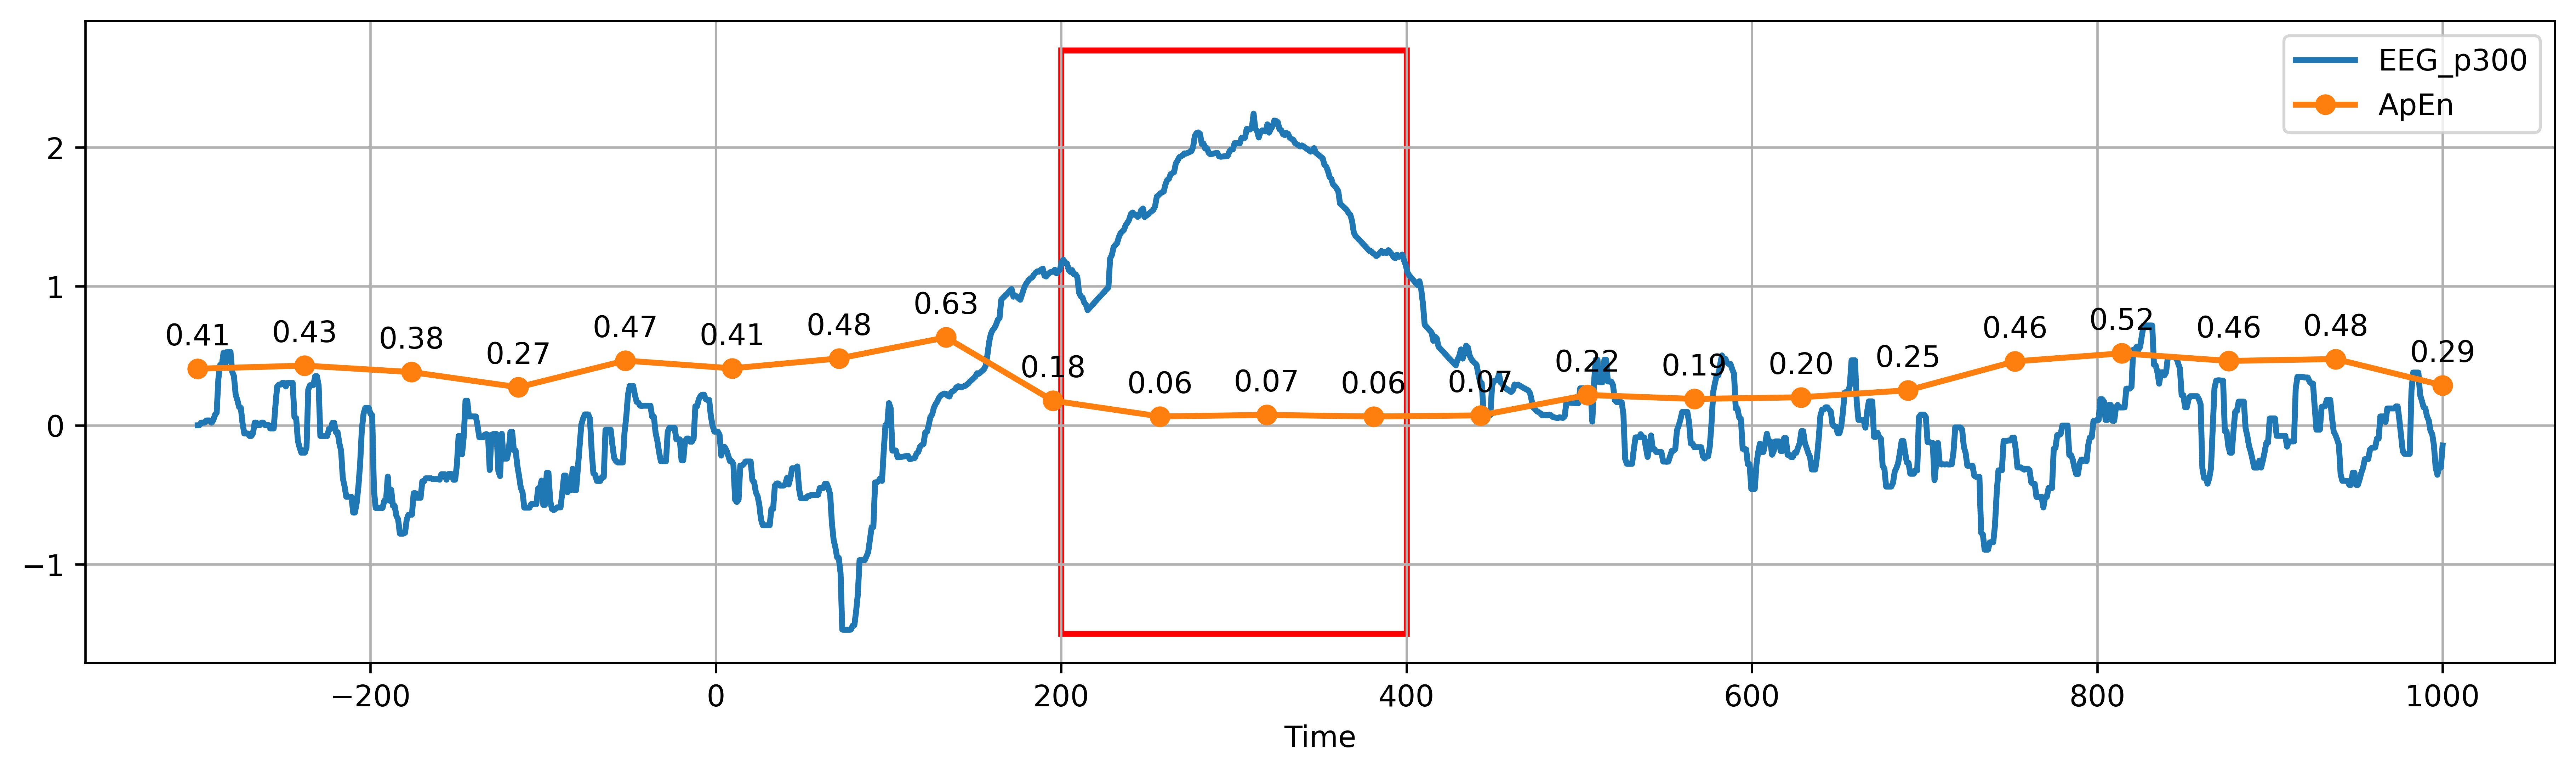

In [196]:
# plt.figure(figsize=(15,4),dpi = 600)
fig, ax = plt.subplots(figsize=(15,4), dpi = 600)
t1 = np.linspace(-300,1000,22)
plt.plot(t, EEG_p300, linewidth=2, label='EEG_p300')
plt.plot(t1, apEnA, linewidth=2, marker='o', label='ApEn')
# 添加矩形框
rect = Rectangle((200, -1.5), 200, 4.2, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.xlabel('Time')
plt.legend()
plt.grid(True)
# 添加点的数值标签
for i in range(len(apEnA)):
    plt.annotate(f'{apEnA[i]:.2f}', (t1[i], apEnA[i]), textcoords="offset points", xytext=(0,8), ha='center')
plt.savefig('fig//P300_ApEn.jpg')
plt.show()